# Run experiments

### Load packages

In [1]:
import numpy as np
from qiskit import IBMQ

from src.analysis.analysis import run_circuits, analyze_results, ExperimentConfiguration, RunConfiguration, PhysicalModel
from src.analysis.constants import SIMULATOR
from src.analysis.error_mitigation import CustomErrorMitigation, IgnisErrorMitigation
from src.models.constants import Groups

### Load account



In [2]:
IBMQ.load_account()
PROVIDER = IBMQ.get_provider(hub='', group='', project='')
PROVIDER.backends()
BACKEND_HARDWARE = '' # Add here physical backend to run
BACKEND_SIMULATOR = PROVIDER.get_backend(SIMULATOR)

### Define experiments
The experiment below uses a square Z2 plaquette with g=1.0 and analyzes the time evolution with a value of t between 0 and 2 in increments of 0.2. It uses zne extrapolation (via Mitiq) and five scale factors. In these examples we use the qasm_simulator. For real results, replace BACKEND_SIMULATOR by BACKEND_HARDWARE.

Note: The number of scale factors determines the type of extrapolation to use during the analysis phase. For example, when using a second order polynomial to extrapolate to zero noise, anything less or equal to three factors would result in over-fitting.

In [3]:
time_vector = np.arange(0, 2, 0.2)
physical_model = PhysicalModel(number_links=4, gauge=Groups.Z2, coupling=1.0)
print(physical_model)

experiment_configuration = ExperimentConfiguration(zne_extrapolation=True,
                                                   scale_factors=[1.0, 1.2, 1.5, 1.8, 2.0],
                                                   num_replicas=2)
print(experiment_configuration)

run_configuration_simulator = RunConfiguration(time_vector=time_vector,
                                               backend=BACKEND_SIMULATOR)

print(run_configuration_simulator)

PhysicalModel(plaquette=<class 'src.models.circuits.SinglePlaquette'>, number_links=4, coupling=1.0, control_qubit=1, gauge='z2')
ExperimentConfiguration(output_error_correction=False, zne_extrapolation=True, scale_factors=[1.0, 1.2, 1.5, 1.8, 2.0], optimisation_level=2, num_replicas=2)
RunConfiguration(time_vector=array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]), backend=<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='hu-berlin-1', project='main')>, shots=1000)


## Run experiments

In [ ]:
job_manager_sim, hpc_sim_job_id, circuits_sim = run_circuits(physical_model, experiment_configuration, run_configuration_simulator)

In [5]:
hpc_res_job = job_manager_sim.retrieve_job_set(job_set_id=hpc_sim_job_id, provider=PROVIDER)

In [6]:
hpc_res_job.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

#### Retrieve experiments results

In [7]:
hpc_res_sim = hpc_res_job.results()

The next cell saves the count results from the experiment so they can be recovered later if necessary.

In [ ]:
import pickle

pickle.dump([hpc_res_sim.get_counts(i) for i in range(len(time_vector))], open("exp_result_counts.pickle", 'wb'))

### Build ignis error filter
The ignis package is used for output error mitigation. It is useful for circuits with a small number of qubits (n) as the ones used for the single plaquette. The cell below executes the 2^n experiments necessary to perform output error mitigation.

In [8]:
ignis_err_corr = IgnisErrorMitigation(n_qubits=5, shots=1000)
meas_filter = ignis_err_corr.get_meas_fitter(backend=BACKEND_SIMULATOR)

### Analyze results from the experiments

The result is a dataframe with the measurements of all observables based on the experiment configurations

In [9]:
results_df = analyze_results(physical_model, experiment_configuration, run_configuration_simulator, result_hpc=hpc_res_sim, meas_filter=meas_filter)

In [10]:
results_df.head()

,replica,scale_factor,time,gauss_law,gauss_law_corrected,sector_2,sector_2_corrected,gauss_law_squared,gauss_law_squared_corrected,original,output_corrected
0,0.0,1.0,0.0,1.0,1.0,0.0,1.798138e-11,0.0,1.151705e-09,1.0,1.0
1,0.0,1.2,0.0,1.0,1.0,0.0,8.685279e-12,0.0,5.569776e-10,1.0,1.0
2,0.0,1.5,0.0,1.0,1.0,0.0,9.924747e-13,0.0,6.347507e-11,1.0,1.0
3,0.0,1.8,0.0,1.0,1.0,0.0,0.000000e+00,0.0,0.000000e+00,1.0,1.0
4,0.0,2.0,0.0,1.0,1.0,0.0,6.573415e-12,0.0,4.203611e-10,1.0,1.0


### Run experiments using custom error correction.
Only probability density observable is supported when using custom error correction.


In [ ]:
error_correction = CustomErrorMitigation(n_qubits=5, shots=1000)
error_correction = error_correction.build_probability_matrix(backend=BACKEND_HARDWARE)

In [ ]:
results_df_custom = analyze_results(physical_model, experiment_configuration, run_configuration_simulator, result_hpc=hpc_res_sim, ignis=False, mitigated_counts=error_correction)

## Analyze experiments

### Plot time evolution
The code below is an example plot generated from the results dataframe. It plots g t in the x axis vs the probability amplitude for the '00000' state in the y axis. The plot displays the untreated results (not corrected), readout only corrected and readout + zero noise extrapolation using mitiq.

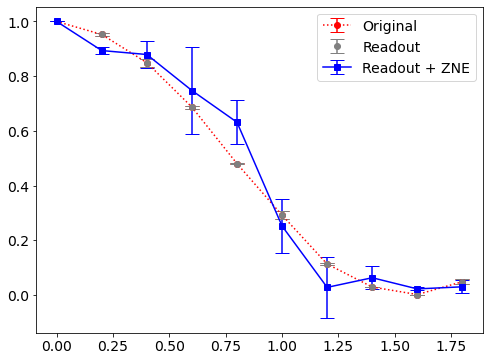

In [11]:
from src.plotting.time_evolution import plot_time_evolution

plot_time_evolution(df_results=results_df)